## NLP Project 

In [ ]:
Probelm Statement :  We are trying to find out if a customer is satisfied with our new product or not. If Not then we will launch campaign foir that
    language detection -----> language translation ----> EDA ----> 1. clustering 2.creating target column with existing features that we have----> preprocessing----> Model Building ---> deploy model ----->model versioning-----> model monitoring

## Data Collection

In [ ]:
1 pdf ---> py2pdf 
2.images ---> pytesseract
3.json ---> df = pd.read_json('.json',lines=True)
             df.to_csv(".csv")
4.Webscrapping




In [72]:
import pandas as pd
from langdetect import detect
from googletrans import Translator
import time 
from joblib import Parallel,delayed
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from numpy import vectorize
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import nltk
from string import punctuation
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [2]:
df = pd.read_csv(r'C:\Users\nilut\Downloads\dataset_es_train.csv')
df.head(2)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics


In [3]:
df.review_body[1]

'Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo'

In [4]:
def language_detection(data):
    lang = detect(data)
    return lang

#textblob

In [5]:
language_detection(df.review_body[1])

'es'

In [6]:
def language_translation(data):
    translator = Translator()
    trans = translator.translate(data,src='es',dest='en')
    return trans.text

# google translation 
# with help of neural networks

In [7]:
language_translation(df.review_body[1])

'Horrible, we had to buy another one because neither we who know English, nor a computer technician, after an hour was able to install it'

In [8]:
df.review_body[1]

'Horrible, nos tuvimos que comprar otro porque ni nosotros que sabemos inglés, ni un informático, después de una hora fue capaz de instalarlo'

In [9]:
language_Translation = list(map(lambda x : language_translation(x),df.review_body))

(200000, 8)

In [29]:
class Serialized():
    '''A class for more effective processing of large scale data'''
    #-------------------------------------------------------------------------------------
    def __init__(self,n_jobs, df, df_name, limit=1500, chunks=10):
        '''n_jobs: int : The number of workers required for processing
        df : pandas.DataFrame object : The main dataframe to perform all the operations on
        df_name : str : The exact same name as the variable name of the main DataFrame
        limit : int : The max limit to be ignored before chunking (default : 1500)
        chunks : int : number of splits the dataframe is to be broken into (default : 10)
        
        Note : The class uses numpy vectorize and joblib Parallel and delayed functions to parallelize and optimize the workflows.'''
        
        self.n_jobs = n_jobs
        self.df = df
        self.df_name = df_name
        self.limit = limit
        self.chunks = chunks
        print('Initialized !'.center(114,'-'))
    #-------------------------------------------------------------------------------------
    @staticmethod
    def language_detection(data):
        '''Detects the language of the text data been passed.
        data : str : text data to perform the language detection on
        returns : str : detected language code'''
        lang = detect(data)
        return lang
    #-------------------------------------------------------------------------------------
    @staticmethod
    def language_translation(data,lang):
        '''Translates the data been passed from the described language to English
        data : str : text data to perform the language detection on
        lang : str : language the text data passed is in
        returns : str : translated text'''
        translator = Translator()
        trans = translator.translate(data,src='auto',dest='en')
        return trans.text
    #-------------------------------------------------------------------------------------    
    def size_maker(self):
        '''Based on the no of splits or chunks prescribed, this function would split the dataframe into equal number of chunks and would return string expressions to access the same directly
        returns : list : a list of expression-like strings that can be used to access the chunks of data directly'''
        if self.df.shape[0] >= self.limit:
            chunk_size = self.df.shape[0]//self.chunks
            seps = [i*chunk_size for i in range(self.chunks)]
            final = [f'{self.df_name}[{seps[i]}:]' if seps[i]==seps[-1] else f'{self.df_name}[{seps[i]}:{seps[i+1]}]' for i in range(len(seps))]
        else:
            final = [f'{self.df_name}[:]']
        return final
    #-------------------------------------------------------------------------------------
    def parallelized_translator(self, function_object, df, cols_list):
        '''Function to perform the translator function effectively on large scale data
        function_object : method-object : vectorized  method-object of the translator method
        df : pandas.DataFrame : dataframe to perform translation on
        cols_list : list : list of strings consisting of the name of column to be translated followed by the name of the language column
        returns : dataframe : modified version of the original dataframe with an additional column having "_translated" suffix corresponding to the column been translated'''
        dataframe = df.copy()
        col1, col2 = f'dataframe["{cols_list[0]}"]', f'dataframe["{cols_list[1]}_refined"]'
        dataframe[f'{cols_list[0]}_translated'] = Parallel(n_jobs=self.n_jobs)(delayed(function_object)(obj1,obj2) for obj1,obj2 in zip(eval(col1),eval(col2)))
        return dataframe
    #-------------------------------------------------------------------------------------
    def parallelized_lang_refiner(self, function_object, df, cols_list):
        '''Function to perform language identification of the column to be translated
        function_object : method-object : vectorized method-object of the language detector method
        df = pandas,DataFrame : dataframe to perform the operations on
        cols_list : list : list of strings consisting of the name of column to be translated followed by the name of the language column
        returns : dataframe : modified version of the original dataframe with an additional column having "_refined" suffix corresponding the column on which the language detection has been performed
        '''
        dataframe = df.copy()
        translatable_column, language_column = f'dataframe["{cols_list[0]}"]', cols_list[1]
        dataframe[f'{language_column}_refined'] = Parallel(n_jobs=self.n_jobs)(delayed(function_object)(item) for item in eval(translatable_column))
        return dataframe
    #-------------------------------------------------------------------------------------
    def serialize(self, translatable_column, language_column):
        '''Function to detect the language and then perform the language translation in an effective and more optimized way
        language_column : str : name of the column on which the language identification is to be performed
        translatable_column : str : name of the column to be translated
        returns : dataframe : modified version of the original dataframe with additional columns having "_refined" and '_translated' suffix corresponding to the column on which the language detection has been performed and the column been translated'''
        datasets = self.size_maker()
#         print(datasets)

        all_cols = list(self.df.columns)
        all_cols.append(f'{language_column}_refined')
        all_cols.append(f'{translatable_column}_translated')
        
        cols_list = (translatable_column, language_column)
        final = pd.DataFrame(columns=all_cols)
        
        refiner_vct_fn = vectorize(Serialized.language_detection)
        translator_vct_fn = vectorize(Serialized.language_translation)
                
        start = time.time()
        for set_ in datasets:
            data = eval(set_)
            print(f'Number of records : {data.shape[0]}')
            print(f'Set working on : {set_}')
            
#             Generating the new and refined language column
            data = self.parallelized_lang_refiner(function_object = refiner_vct_fn, df = data, cols_list = cols_list)
#             Translating the target column
            data = self.parallelized_translator(function_object = translator_vct_fn,df = data, cols_list = cols_list)
            
            final = final.append(data, ignore_index=True)
            print('-'*114)
        print('Completed'.center(114,'-'))
        end = time.time()
        print(f'Total time elapsed : {end-start} sec')
        return final

In [30]:
sr_obj = Serialized(n_jobs=50, df = sample, df_name = 'sample', limit = 2000, chunks = 15)
sr_obj.size_maker()

--------------------------------------------------Initialized !---------------------------------------------------


['sample[0:1333]',
 'sample[1333:2666]',
 'sample[2666:3999]',
 'sample[3999:5332]',
 'sample[5332:6665]',
 'sample[6665:7998]',
 'sample[7998:9331]',
 'sample[9331:10664]',
 'sample[10664:11997]',
 'sample[11997:13330]',
 'sample[13330:14663]',
 'sample[14663:15996]',
 'sample[15996:17329]',
 'sample[17329:18662]',
 'sample[18662:]']

In [21]:
sr_obj1 = Serialized(n_jobs=50, df = sample, df_name = 'sample', limit = 2000, chunks = 7)
dummy1 = sr_obj1.size_maker()

--------------------------------------------------Initialized !---------------------------------------------------


In [28]:
x = sum
x([1,2])

3

In [16]:
sample = df.sample(n = 20000, ignore_index=True,random_state=11)
print(f'Working on {sample.shape[0]} records !')

sr_obj = Serialized(n_jobs=50, df = sample, df_name = 'sample', limit = 2000, chunks = 15)
test = sr_obj.serialize(translatable_column = 'review_body', language_column = 'languages')

Working on 20000 records !
--------------------------------------------------Initialized !---------------------------------------------------
Number of records : 1333
Set working on : sample[0:1333]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1333
Set working on : sample[1333:2666]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1333
Set working on : sample[2666:3999]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1333
Set working on : sample[3999:5332]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1333
Set working on : sample[5332:6665]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1333
Set working on : sample[6665:7998]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1333
Set working on : sample[7998:9331]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1333
Set working on : sample[9331:10664]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1333
Set working on : sample[10664:11997]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1333
Set working on : sample[11997:13330]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1333
Set working on : sample[13330:14663]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1333
Set working on : sample[14663:15996]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1333
Set working on : sample[15996:17329]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1333
Set working on : sample[17329:18662]


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


------------------------------------------------------------------------------------------------------------------
Number of records : 1338
Set working on : sample[18662:]
------------------------------------------------------------------------------------------------------------------
----------------------------------------------------Completed-----------------------------------------------------
Total time elapsed : 341.3353531360626 sec


C:\Users\nilut\AppData\Local\Temp\ipykernel_14672\597148415.py:101: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final = final.append(data, ignore_index=True)


In [31]:
test.drop(['review_id','product_id','reviewer_id','review_body','review_title','product_category','language'],axis=1,inplace=True)

In [32]:
test.head(2)

,stars,languages_refined,review_body_translated
0,4,es,I bought this hub because of the good referenc...
1,2,es,"After 5 days of operation, the bracelet has fa..."


### N grams 

In [ ]:
text = ' bought this hub because of the good reference'
keyphrase extraction --- 1. Ngram 
                         2. with help of algorithms - 1.Yake 2. Rake 3.Page Ranking 3. word embedding
    
Ngram - unigram,bigram,trigram,multigram -- 

unigram - bought,this,hub,because....
bigram  - bought this,this hub,hub because,because of .....
trigram - bought this hub,this hub because,hub because of....

## EDA 

Machine Learning : Univariate Analysis,Bivariate Analysis,Multivariate Analysis

Text Data : bar chart ,wordcloud

### Unigrams Visulization  with stopwords

In [33]:
test.review_body_translated= test.review_body_translated.apply(lambda x : str(x))

In [34]:
def get_ngrams(df,n=None):
    cv = CountVectorizer()
    bag_of_words = cv.fit_transform(df)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word,sum_of_words[0,i]) for word,i in cv.vocabulary_.items()]
    word_freq = sorted(word_freq,key = lambda x:x[1],reverse=True)
    return word_freq[:n]


common_words = get_ngrams(test.review_body_translated,25)


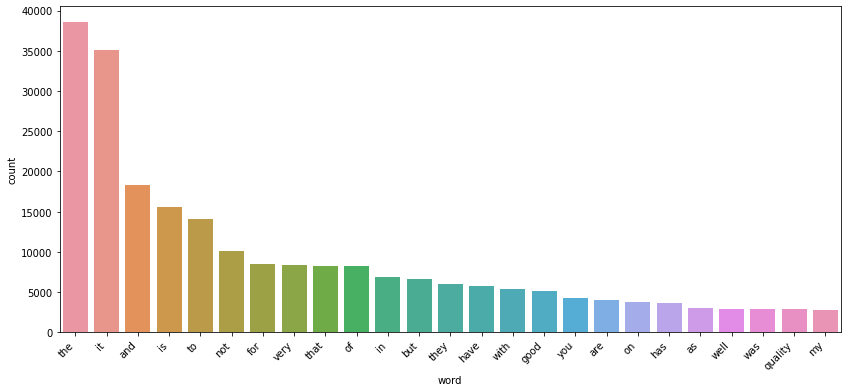

In [35]:
df_ngrams =pd.DataFrame(common_words,columns =['word','count'])
df_ngrams = df_ngrams.groupby('word').sum()['count'].sort_values(ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(14,6))
fig = sns.barplot(x='word',y='count',data=df_ngrams,ax =ax)
ax.set_xticklabels(labels=df_ngrams['word'],rotation =45,ha='right')
plt.show()

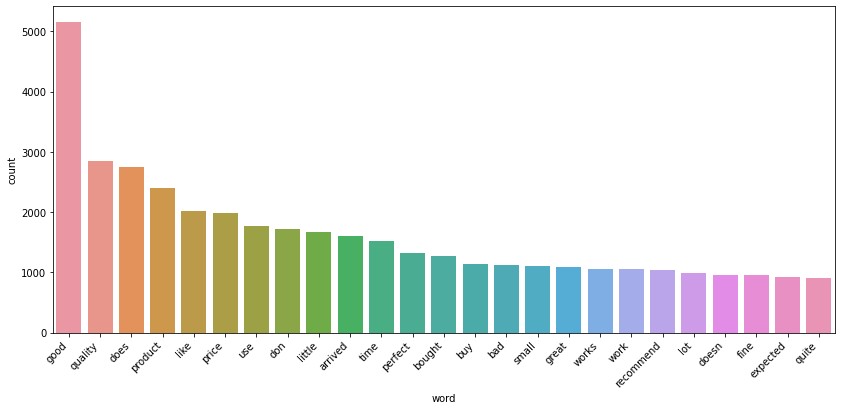

In [36]:
def get_ngrams(df,n=None):
    cv = CountVectorizer(stop_words='english')
    bag_of_words = cv.fit_transform(df)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word,sum_of_words[0,i]) for word,i in cv.vocabulary_.items()]
    word_freq = sorted(word_freq,key = lambda x:x[1],reverse=True)
    return word_freq[:n]


common_words = get_ngrams(test.review_body_translated,25)
df_ngrams =pd.DataFrame(common_words,columns =['word','count'])
df_ngrams = df_ngrams.groupby('word').sum()['count'].sort_values(ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(14,6))
fig = sns.barplot(x='word',y='count',data=df_ngrams,ax =ax)
ax.set_xticklabels(labels=df_ngrams['word'],rotation =45,ha='right')
plt.show()

In [ ]:
from collections import Counter
Counter.most_common(100) ---- > ('word': word_count) []

### Bigrams Visulization  with stopwords


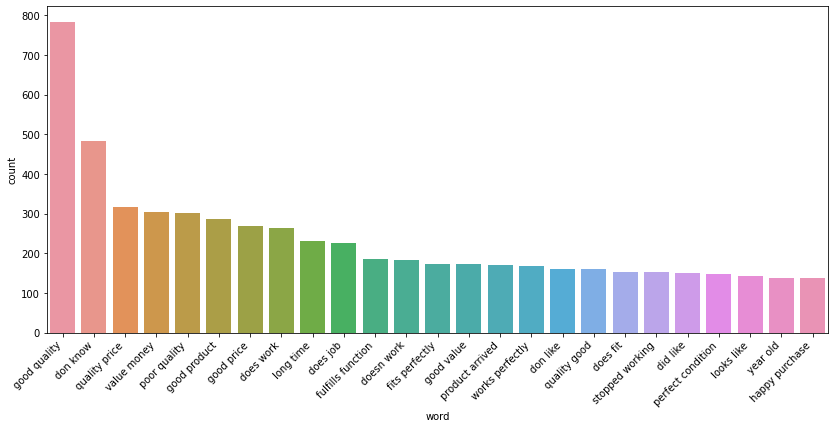

In [37]:
def get_bigrams(df,n=None):
    cv = CountVectorizer(ngram_range=(2,2),stop_words='english')
    bag_of_words = cv.fit_transform(df)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word,sum_of_words[0,i]) for word,i in cv.vocabulary_.items()]
    word_freq = sorted(word_freq,key = lambda x:x[1],reverse=True)
    return word_freq[:n]


common_words = get_bigrams(test.review_body_translated,25)
df_ngrams =pd.DataFrame(common_words,columns =['word','count'])
df_ngrams = df_ngrams.groupby('word').sum()['count'].sort_values(ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(14,6))
fig = sns.barplot(x='word',y='count',data=df_ngrams,ax =ax)
ax.set_xticklabels(labels=df_ngrams['word'],rotation =45,ha='right')
plt.show()

### Trigrams Visulization  with stopwords


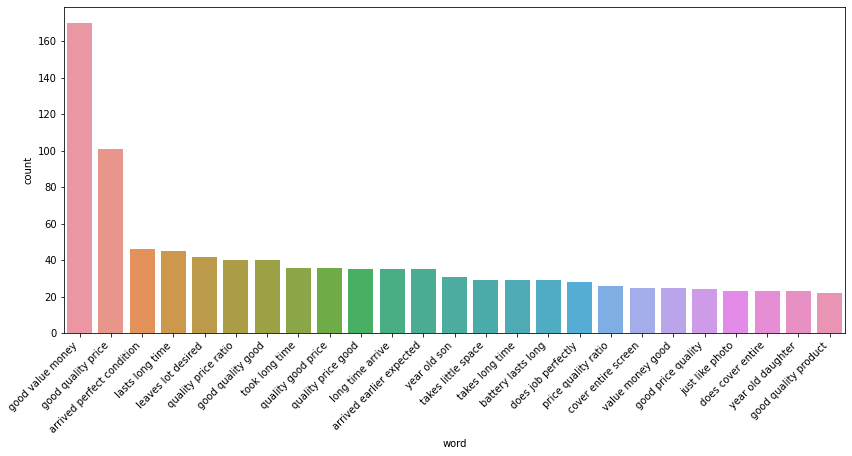

In [38]:
def get_bigrams(df,n=None):
    cv = CountVectorizer(ngram_range=(3,3),stop_words='english')
    bag_of_words = cv.fit_transform(df)
    sum_of_words = bag_of_words.sum(axis=0)
    word_freq = [(word,sum_of_words[0,i]) for word,i in cv.vocabulary_.items()]
    word_freq = sorted(word_freq,key = lambda x:x[1],reverse=True)
    return word_freq[:n]


common_words = get_bigrams(test.review_body_translated,25)
df_ngrams =pd.DataFrame(common_words,columns =['word','count'])
df_ngrams = df_ngrams.groupby('word').sum()['count'].sort_values(ascending=False).reset_index()

fig,ax = plt.subplots(figsize=(14,6))
fig = sns.barplot(x='word',y='count',data=df_ngrams,ax =ax)
ax.set_xticklabels(labels=df_ngrams['word'],rotation =45,ha='right')
plt.show()

In [ ]:
# dataset with other column visualization
# wordcloud 

# Preprocessing 

### Tokenization

In [39]:
def tokenization(data):
    text = word_tokenize(data)
    return text 

In [40]:
tokens = test.review_body_translated.apply(tokenization)

In [59]:
tokens

0        [I, bought, this, hub, because, of, the, good,...
1        [After, 5, days, of, operation, ,, the, bracel...
2        [100, %, recommended, ,, beautiful, and, comfo...
3        [The, channel, is, paid, so, do, n't, use, the...
4        [The, first, one, I, bought, did, n't, last, l...
                               ...                        
19995    [If, the, size, is, perfect, and, you, are, en...
19996    [They, do, n't, last, as, long, as, the, origi...
19997    [I, would, have, put, more, weight, on, it, fo...
19998    [It, seems, to, protect, well, but, the, rear,...
19999    [The, transformers, of, the, 2, that, I, bough...
Name: review_body_translated, Length: 20000, dtype: object

### Cleaning 

In [42]:
def cleaning(data):
    text = [i for i in data if i not in punctuation]
    return text 
clean_tokens = tokens.apply(cleaning)

In [43]:
clean_tokens

# 

0        [I, bought, this, hub, because, of, the, good,...
1        [After, 5, days, of, operation, the, bracelet,...
2        [100, recommended, beautiful, and, comfortable...
3        [The, channel, is, paid, so, do, n't, use, the...
4        [The, first, one, I, bought, did, n't, last, l...
                               ...                        
19995    [If, the, size, is, perfect, and, you, are, en...
19996    [They, do, n't, last, as, long, as, the, origi...
19997    [I, would, have, put, more, weight, on, it, fo...
19998    [It, seems, to, protect, well, but, the, rear,...
19999    [The, transformers, of, the, 2, that, I, bough...
Name: review_body_translated, Length: 20000, dtype: object

In [44]:
# regular expression -advance 
#  tags =html  tags
# api links 
# numerical format 

  ### Normalization

In [45]:
def normalization(data):
    text = [i.lower() for i in data ]
    return text 
tokens_lower = clean_tokens.apply(normalization)

### stopwords removal

In [46]:
stop = stopwords.words('english')


In [69]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nilut\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [47]:
def stopwords_removal(data):
    text = [i for i in data if i not in stop ]
    return text 
tokens_without_stop = tokens_lower.apply(stopwords_removal)

### Stemming or Lemmatization

In [48]:
def lemmatization(data):
    lemma = WordNetLemmatizer()
    l1 = []
    for i in data :
        lemmatized = lemma.lemmatize(i)
        l1.append(lemmatized)
    return l1 
tokens_lemma= tokens_without_stop.apply(lemmatization)

In [75]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nilut\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

### Target Column

In [49]:
test.stars.unique()

array([4, 2, 3, 1, 5], dtype=object)

In [51]:
def target_column(data):
    if (data==1) or (data==2):
        return  'Not Satisfied'
    elif data==3:
        return 'Satisfied'
    elif (data==4) or (data==5):
        return 'Happy'

In [54]:
test['target'] = test.stars.apply(target_column)

In [55]:
test.head(2)

,stars,languages_refined,review_body_translated,target
0,4,es,I bought this hub because of the good referenc...,Happy
1,2,es,"After 5 days of operation, the bracelet has fa...",Not Satisfied


### Clustering -- > Kmeans 

1. Kmeans Clustering 
2. Hierarchical CLustering 
3. SOM Clustering

In [57]:
vectorizer = TfidfVectorizer(stop_words='english')
x= vectorizer.fit_transform(test.review_body_translated.tolist())

In [59]:
from sklearn.cluster import KMeans

In [60]:
model = KMeans(n_clusters=3,max_iter=200,n_init=10)
model.fit(x)
labels = model.labels_
kmeans_df = pd.DataFrame(list(zip(test.review_body_translated,labels)),columns=['text','cluster'])
kmeans_df.head(2)

,text,cluster
0,I bought this hub because of the good referenc...,0
1,"After 5 days of operation, the bracelet has fa...",2


In [62]:
labels

array([0, 2, 0, ..., 1, 0, 0])

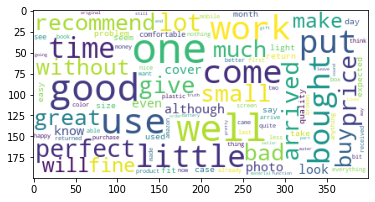

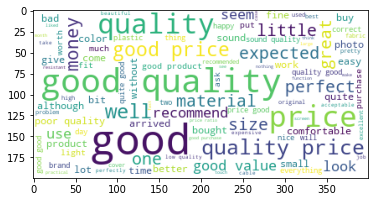

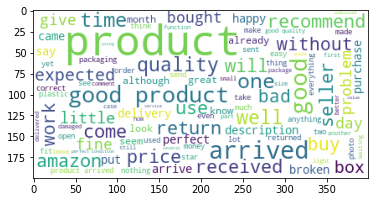

In [68]:
from wordcloud import WordCloud
result = {'cluster':labels,'text':test.review_body_translated}
result = pd.DataFrame(result)
for k in range(0,3):
    s = result[result.cluster==k]
    text = s['text'].str.cat(sep=" ")
    text = text.lower()
    text = " ".join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50,max_words=100,background_color='white')
    wordcloud = wordcloud.generate(text)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis='off'
    plt.show()

### Train Test Split 

In [76]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(test.review_body_translated,test.target,random_state=42)

from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
y_final_train = label.fit_transform(y_train)
y_final_test = label.transform(y_test)

In [77]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf_multinb_pipe = Pipeline([('vect',CountVectorizer()),('clf_nmb',MultinomialNB())])
clf_multinb_pipe.fit(x_train,y_final_train)

Pipeline(steps=[('vect', CountVectorizer()), ('clf_nmb', MultinomialNB())])

In [ ]:
# PCA = Principle Component Analysis
# T SNE 

In [78]:
predict_y = clf_multinb_pipe.predict(x_test)

In [79]:
predict_y

array([1, 1, 0, ..., 0, 1, 0])

In [80]:
from sklearn.metrics import accuracy_score
accuracy_score(y_final_test,predict_y)

0.6812

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier_pipe = Pipeline([('vect',CountVectorizer()),('clf_random',RandomForestClassifier())])
RandomForestClassifier_pipe.fit(x_train,y_final_train)

Pipeline(steps=[('vect', CountVectorizer()),
                ('clf_random', RandomForestClassifier())])

In [ ]:
# pca 
# tsme

In [82]:
predict_y = RandomForestClassifier_pipe.predict(x_test)
accuracy_score(y_final_test,predict_y)

0.6796

In [ ]:
# logistic regression 
# SVM 
# adaboost 
# GB 
# XGB

### Model Monitoring 

In [ ]:
data drift ----> model drift 

model 1(XGB) - past data = 90% 
model 2(SVM) - past data = 75%  


model 1 60 % 
model 2 85 %   

if max_accuracy(model1,model2):
    return model1

# model monitoring 

In [ ]:
final function(data)

data ---> pipeline ---> result 
pipeline - 1 cleaning.py
           2 clustering.py 
           3 final_preprocessing.py 
           4 predict.py
            
model - 1. xgb.pkl
        2. gb.pkl
    
data = hourly basis,monthly,quarterly,yearly
review --- pipeline - predict -- result 

transaltion = i/p --> o/p

In [ ]:
cleaning.py 
preprocessing.py 
clustering.py 
prediction